# Stock Classification

## Table of Contents:
1. [Summary of Notebook](#Summary)
2. [Environment Setup](#env_setup)
3. [Data Loading and Preprocessing](#load_preproc)
4. [Feature Engineer](#feature_eng)
5. [EDA on Some Features](#eda)
6. [XGBoost Model](#xgboost)
    1. [Data Split,Model Training, and Hyperparamters Tuning](#train)
    2. [Model Predictions on Train and Test](#predictions)
    3. [Calibration Curves](#calibration_curves)
7. [Results on Different Metrics and Confusion Matrix](#results)
8. [XGBoost Features Importance](#features_imp)

## Summary of Notebook <a id='Summary'></a>

**Project Background**: Global Industry Classification Standard (GICS) is a common global classification standard used by thousands of market participants across all major groups involved in the investment process. Each stock in the S&P 500 belongs to a GICS sector such as Information Technology, Financials, Industrials, Health Care, etc. Moreover, every GICS also has subsectors.

**Project Goal**: Given the multiple daily time series of a stock (Open, Close, High, Low, Adjusted Price, and Volume), predict the GICS sector of given stock.

**Methods**: Dataset contains multiple daily time series of $358$ stocks obtained from yahoo finance (after filtering from $500$ stocks) from the start of $2016$ till the end of $2018$, and the GICS sector obtained from wikipedia is chosen to be the label to be predicted. The features were mostly generated by tsfresh library and hurst exponent. Exploratory data analysis is carried out on useful features. Processed data is then used in an XGBoost model to predict GICS sector.

## Environment Setup  <a id='env_setup'></a>

Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import os
import sys
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter

import numpy as np                            
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score,balanced_accuracy_score, matthews_corrcoef, classification_report
from sklearn.calibration import calibration_curve

from IPython.display import display

List of directories

In [3]:
DIRECTORY_DATA = '../data/external/'

DIRECTORY_TICKERS = '../data/inter/tickers/'

DIRECTORY_INTER = '../data/inter/'

TICKERS_FILENAME = 'tickers.pkl'

DF_STOCKS_FILENAME = 'df_stocks_full.pkl'

DF_FINAL_FILENAME = 'df_final_full.pkl'

XGBOOST_FILENAME = 'xgboost_model.pkl'

In [4]:
if '../src' not in sys.path:
    sys.path.append('../src')
    
import utils

Global variables

In [5]:
NUMBER_DAYS = 754
RANDOM_STATE_SPLIT = 43
RANDOM_SEED_XGBOOST = 42

## Data Loading and Preprocessing <a id='load_preproc'></a>

In [6]:
tickers = pd.read_pickle(os.path.join(DIRECTORY_TICKERS,TICKERS_FILENAME))
tickers_sector = tickers[['Symbol','GICS Sector']].copy()

In [7]:
df_stocks = utils.load_preprocess(DIRECTORY_DATA,DIRECTORY_INTER,DF_STOCKS_FILENAME,tickers_sector)

## Feature Engineering <a id='feature_eng'></a>

tsfresh features that are going to be generated on `HL`, `OC`, `Adj Close`, and `Volume` columns.

In [8]:
fc_parameters = {'sum_values': None, 'abs_energy': None, 'mean_abs_change': None,'mean_change': None,
                 'median': None,'mean': None,'standard_deviation': None,'variation_coefficient': None,
                 'variance': None,'skewness': None, 'kurtosis': None,'root_mean_square': None,
                 'absolute_sum_of_changes': None, 'longest_strike_below_mean': None,'longest_strike_above_mean': None,
                 'count_above_mean': None,'count_below_mean': None,'last_location_of_maximum': None,
                 'first_location_of_maximum': None,'last_location_of_minimum': None,'first_location_of_minimum': None,
                 'sum_of_reoccurring_values': None,'maximum': None, 'minimum': None, 
                 'fft_aggregated': [{'aggtype': 'centroid'}, 
                                    {'aggtype': 'variance'},
                                    {'aggtype': 'skew'},
                                    {'aggtype': 'kurtosis'}]}

Tsfresh features and Hurst exponent on `HL`, `OC`, `Adj Close`, and `Volume` will be generated. `HL` column denotes the highest minus lowest daily price, and `OC` column denotes open minus close daily price. The Hurst exponent is used as a measure of long-term memory of time series. If the Hurst exponent is more than $\frac{1}{2}$, then it would indicate a persistent time series (trending market). In a persistent time series an increase in values will most likely be followed by an increase in the short term and a decrease in values will most likely be followed by another decrease in the short term. On the other hand, if Hurst exponent is less than $\frac{1}{2}$, then it would indicate an anti-persistent time series (mean-reverting market). In an anti-persistent time series (also known as a mean-reverting series) an increase will most likely be followed by a decrease or vice-versa (i.e., values will tend to revert to a mean). This means that future values have a tendency to return to a long-term mean. And finally, if the Hurst exponent is equal to $\frac{1}{2}$, then it would indicate a random walk.

In [9]:
df_final = utils.feature_generation(df_stocks,fc_parameters,tickers_sector,DIRECTORY_INTER,DF_FINAL_FILENAME)

In [10]:
df_final

,Symbol,HL__sum_values,HL__abs_energy,HL__mean_abs_change,HL__mean_change,HL__median,HL__mean,HL__standard_deviation,HL__variation_coefficient,HL__variance,...,Volume__minimum,"Volume__fft_aggregated__aggtype_""centroid""","Volume__fft_aggregated__aggtype_""variance""","Volume__fft_aggregated__aggtype_""skew""","Volume__fft_aggregated__aggtype_""kurtosis""",Volume__hurst,Adj Close__hurst,OC__hurst,HL__hurst,GICS Sector
0,A,732.480026,946.099128,0.393240,0.000385,0.810001,0.971459,0.557710,0.574096,0.311041,...,532700.0,126.348661,13213.093970,0.597092,6.485126,0.889635,0.346376,0.514108,0.897756,Health Care
1,AAL,908.249985,1324.527612,0.495259,-0.000146,1.099998,1.204576,0.552870,0.458975,0.305666,...,1352400.0,126.207571,13866.754135,0.580836,5.986070,0.874435,0.525379,0.489172,0.948822,Industrials
2,AAP,2510.159828,10502.282907,1.383055,-0.005684,2.864998,3.329124,1.686917,0.506715,2.845688,...,325700.0,143.943326,13573.433494,0.402565,8.857025,0.767742,0.445612,0.521968,0.923917,Consumer Discretionary
3,AAPL,468.919987,428.296932,0.252878,-0.000163,0.500000,0.621910,0.425748,0.684581,0.181261,...,45903600.0,120.445242,13379.324193,0.648440,5.662395,0.860844,0.303816,0.587904,0.866397,Information Technology
4,ABBV,1312.120003,3546.161432,0.720398,-0.000212,1.365000,1.740212,1.294138,0.743667,1.674793,...,1612800.0,122.596754,13641.535866,0.632022,5.692348,0.872091,0.307332,0.626878,0.807052,Health Care
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,YUM,785.335587,1100.941465,0.420049,-0.000515,0.889999,1.041559,0.612608,0.588165,0.375289,...,666600.0,120.035113,13198.674846,0.683169,5.744734,0.819920,0.319045,0.579052,0.877104,Consumer Discretionary
354,ZBH,1542.060242,3962.555897,0.860677,-0.001235,1.775002,2.045173,1.035687,0.506406,1.072648,...,268500.0,131.231084,13125.574813,0.515040,7.179314,0.864797,0.549059,0.587165,0.926131,Health Care
355,ZBRA,2142.439999,9425.766824,1.250319,0.001713,2.270004,2.841432,2.104110,0.740510,4.427279,...,81000.0,132.277735,13061.147300,0.543162,7.434989,0.810064,0.290465,0.488526,0.876913,Information Technology
356,ZION,729.919968,862.378946,0.366428,0.000452,0.849999,0.968064,0.454523,0.469518,0.206591,...,651800.0,128.075939,14360.584559,0.535447,5.844908,0.900153,0.307803,0.546748,0.907088,Financials


## EDA on Some Features <a id='eda'></a>

Select a few features that show significant variations among different stocks

In [11]:
useful_features = ['__mean','__variance','__variation_coefficient','__skewness','__kurtosis','__median',
                   '__root_mean_square','__fft_aggregated__aggtype_"centroid"','__fft_aggregated__aggtype_"variance"',
                   '__fft_aggregated__aggtype_"kurtosis"','__hurst','__sum_values','__mean_change',
                   '__last_location_of_minimum']

features = ['HL','OC','Adj Close','Volume']
all_useful_features = [feature+useful_feature for useful_feature in useful_features for feature in features]

The whiskers in the boxplots below indicate the zeroth and 100th percentile for the lower and upper whiskers respectively. The default values are 25th and 75th percentile for the lower and upper whiskers respectively. The green circle is the location of the mean of the distribution.

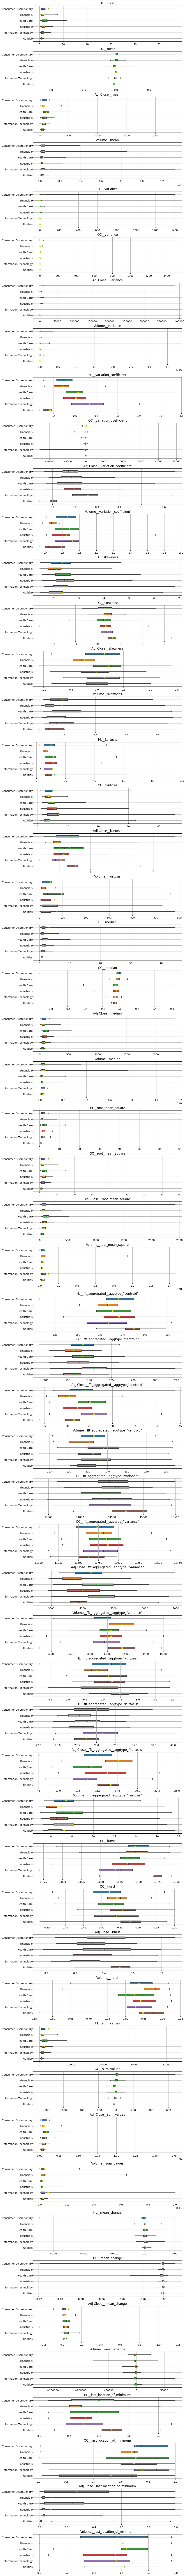

In [12]:
utils.plot_boxplots(df_final,all_useful_features,'GICS Sector',len(all_useful_features))

## XGBoost Model <a id='xgboost'></a>

In [13]:
X = df_final[df_final.columns[~df_final.columns.isin(['Symbol','GICS Sector'])]]
y = df_final[['GICS Sector']]

### Data Split, Model Training, and Hyperparameters Tuning <a id='train'></a>

Divide the dataset into  80%  train and  20%  test, perform stratified sampling, and label the targets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=True,
                                                    stratify=y, random_state = RANDOM_STATE_SPLIT)    
labelencoder = LabelEncoder()
y_train_enc = labelencoder.fit_transform(y_train)
labelencoder = LabelEncoder()
y_test_enc = labelencoder.fit_transform(y_test)
    
mapping = dict(zip(range(len(labelencoder.classes_)), labelencoder.classes_))
sectors = sorted(list(labelencoder.classes_))

/Users/hassansaadi/opt/anaconda3/envs/python39_fin/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
mapping

{0: 'Consumer Discretionary',
 1: 'Financials',
 2: 'Health Care',
 3: 'Industrials',
 4: 'Information Technology',
 5: 'Utilities'}

In [16]:
params = {
    'seed' : [RANDOM_SEED_XGBOOST],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.1, 0.3, 0.5],
    'n_estimators': [50, 100],
    'gamma': [0, 0.2],
    'reg_alpha': [0, 1e-2, 1, 1e1],
    'reg_lambda': [0, 1e-2, 1, 1e1],
    'base_score': [0.5],
    'use_label_encoder': [False]
}

Train the model, and perform hyperparamter tuning.

In [18]:
xgb_cl = utils.train_xgboost(DIRECTORY_INTER,XGBOOST_FILENAME,params,X_train,y_train_enc)

### Model Predictions on Train and Test <a id='predictions'></a>

In [19]:
xgb_preds_train = xgb_cl.predict(X_train)
xgb_preds_test = xgb_cl.predict(X_test)

### Calibration Curves <a id='calibration_curves'></a>

In [20]:
xgb_cl.predict_proba(X_test)

array([[0.0378136 , 0.01545486, 0.2054609 , 0.03232357, 0.6932709 ,
        0.01567613],
       [0.88376164, 0.01179774, 0.02077336, 0.0355445 , 0.04153118,
        0.00659156],
       [0.05482508, 0.07539135, 0.5496468 , 0.14727347, 0.1532139 ,
        0.0196494 ],
       [0.20818411, 0.328252  , 0.04968807, 0.22608764, 0.01938989,
        0.16839826],
       [0.5493074 , 0.12784709, 0.070489  , 0.15051857, 0.06698461,
        0.03485333],
       [0.22117464, 0.04521466, 0.01987374, 0.04185989, 0.65604126,
        0.01583582],
       [0.04256766, 0.7598412 , 0.01945252, 0.14757526, 0.01802253,
        0.01254087],
       [0.07235689, 0.8878818 , 0.00290265, 0.02442342, 0.00972347,
        0.00271171],
       [0.04526783, 0.05877919, 0.13666335, 0.4012074 , 0.3416805 ,
        0.01640178],
       [0.2287676 , 0.0684888 , 0.4317521 , 0.15429881, 0.03836288,
        0.07832983],
       [0.008832  , 0.70678556, 0.01280878, 0.25062   , 0.01642112,
        0.0045325 ],
       [0.02262774, 0

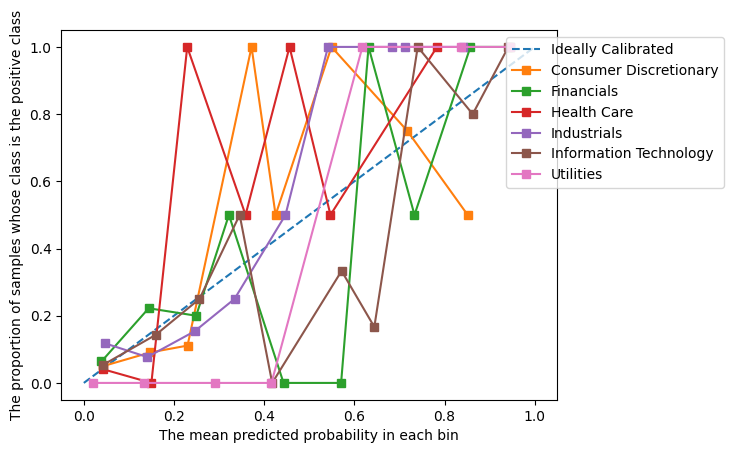

In [21]:
utils.plot_calibration_curves(xgb_cl,labelencoder,X_test,y_test_enc,mapping,sectors)

## Results on Different Metrics and Confusion Matrix <a id='results'></a>

#### Metrics

In [22]:
print('Accuracy = {} \nBalanced Accuracy = {} \nMCC = {}'.format(accuracy_score(y_test_enc, xgb_preds_test), 
                                                                 balanced_accuracy_score(y_test_enc, xgb_preds_test), 
                                                                 matthews_corrcoef(y_test_enc, xgb_preds_test)))

Accuracy = 0.6111111111111112 
Balanced Accuracy = 0.6445054945054945 
MCC = 0.5317266498282758


Balanced accuracy and Matthew's Correlation Coefficients (MCC) are used because the dataset is imbalanced. Balanced accuracy is the mean of classes accuracy. When the outcome classes are the same size, accuracy and balanced accuracy give the same result. MCC take into account all of the elements in the confusion matrix. Its range is between $[-1,1]$ with $1$ means all classes are predicted well, $-1$ means all classes are predicted wrong, and $0$ means that the classifier is no better than a flip of a fair coin. MCC is also known as the phi coefficient. MCC is a reliable statistical rate which produces a high score only if the prediction obtained good results in all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives). MCC is symmetric; hence, it is not sensitive if some classes have more or less samples than others. 


$$Balanced \; Accuracy = \frac{TPR + TNR}{2} = \frac{\frac{TP}{TP+FN} + \frac{TN}{TN+FP}}{2} = \frac{\text{Sensitivity} + \text{Specificity}}{2}$$

$$MCC = \frac{TN \times TP - FP \times FN}{\sqrt{(TN+FN)(FP+TP)(TN+FP)(FN+TP)}}$$


In [23]:
preds_test_comp = [mapping[num] for num in xgb_preds_test]

#### Confusion Matrix

By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus in binary classification, the count of true negatives is $C_{00}$ , false negatives is $C_{10}$, true positives is $C_{11}$ and false positives is $C_{01}$.

<AxesSubplot:>

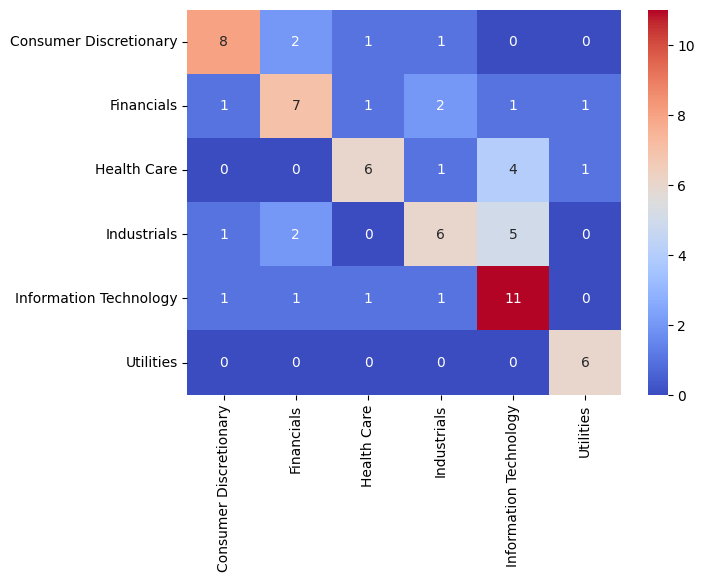

In [24]:
cf_test = confusion_matrix(y_test,preds_test_comp)
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cf_test, annot=True, cmap="coolwarm",yticklabels= sectors, xticklabels= sectors)

Normalized by row (true values) Confusion Matrix

<AxesSubplot:>

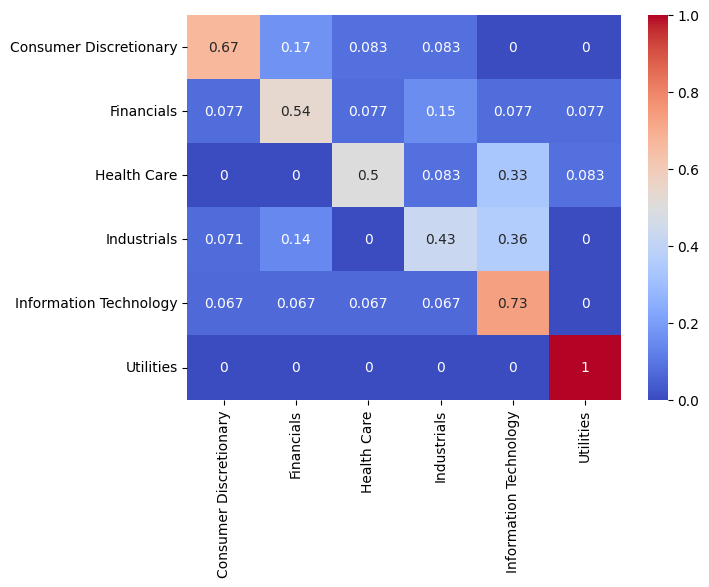

In [25]:
cf_test = confusion_matrix(y_test,preds_test_comp,normalize='true')
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cf_test, annot=True, cmap="coolwarm",yticklabels= sectors, xticklabels= sectors)

## XGBoost Features Importance <a id='features_imp'></a>

Top $30$ important features

In [26]:
feature_important = Counter(xgb_cl.get_booster().get_score(importance_type='weight'))
feature_important = feature_important.most_common(30)
keys = [k for k,v in feature_important]
values = [v for k,v in feature_important]

<AxesSubplot:>

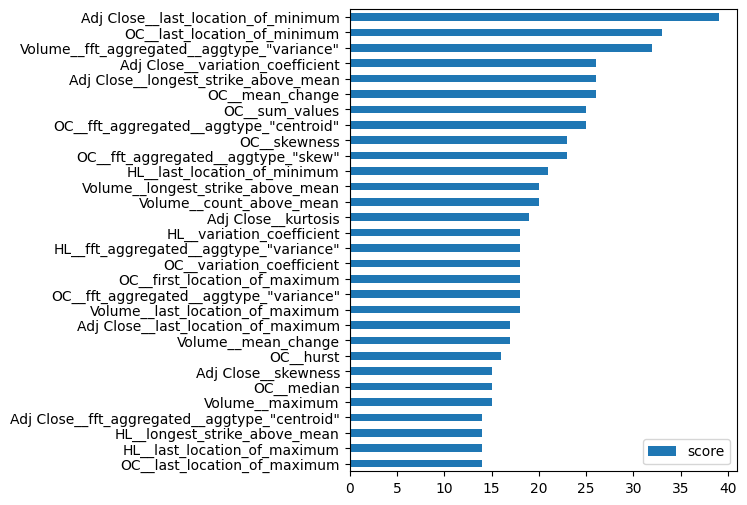

In [27]:
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh',figsize=(5,6))

From the eda plots above, we can notice that some of the features in the above plots are important because they help in distinguishing between different GICS sectors such as:
1. The last location of minimum for Adjusted Close price average point for Consumer Discretionary and Health Care GICS sectors are relatively higher than the other GICS sectors. 
2. The last location of minimum for OC, Adjusted Close price and HL variation coefficients have averages and distributions points for Utilities that are lower than the other GICS sectors.
3. OC sum values for Utilities is almost always negative, which means the close daily price is almost always higher than the open daily price.